# SHAP (SHapley Additive exPlanations). 
This procedure is derived from game theory and aims to understand (or explain) the output of any machine learning model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import tensorflow as tf
from tensorflow import keras

## Train a CNN model

In [2]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

In [3]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation="relu")(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)

# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

2023-12-10 22:26:21.982860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 22:26:21.983029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Epoch 1/5


2023-12-10 22:26:22.230352: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-10 22:26:22.354637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1873/1875 [============================>.] - ETA: 0s - loss: 0.3799 - sparse_categorical_accuracy: 0.8641

2023-12-10 22:26:31.987578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 11s 6ms/step - loss: 0.3798 - sparse_categorical_accuracy: 0.8642 - val_loss: 0.3373 - val_sparse_categorical_accuracy: 0.8797
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.2681 - val_sparse_categorical_accuracy: 0.9020
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2073 - sparse_categorical_accuracy: 0.9244 - val_loss: 0.2699 - val_sparse_categorical_accuracy: 0.9009
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1726 - sparse_categorical_accuracy: 0.9359 - val_loss: 0.2648 - val_sparse_categorical_accuracy: 0.9102
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1425 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.2418 - val_sparse_categorical_accuracy: 0.9178


## Explaining the outputs

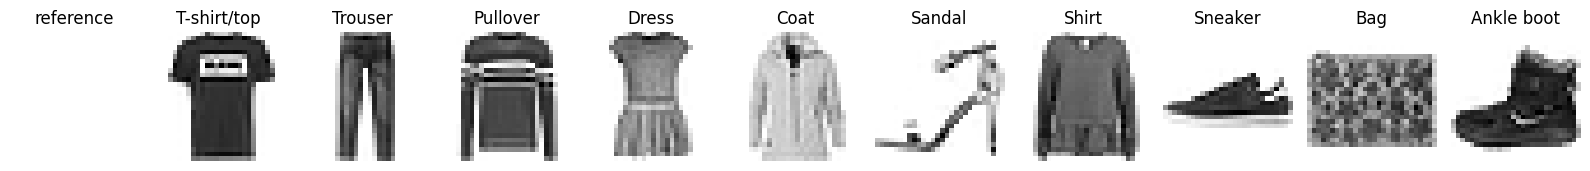

In [4]:
# Name each one of the classes
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
    if len(images_dict) == 10:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()

    # Plot an empty canvas
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype="uint8")
    ax.set_title("reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation="nearest")

    # Plot an image for every category
    for k, v in images.items():
        ax = axes[k + 1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"{class_names[k]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


# Use the function to plot
plot_categories(images_dict)

## DeepExplainer

In [5]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]

# Use DeepExplainer to explain predictions of the model. You can safely ignore the warning about the Tensorflow version in the output.
e = shap.DeepExplainer(model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [6]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict) == 10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


In [7]:
# Compute predictions
predictions = model.predict(x_test_each_class)

# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 45ms/step


2023-12-10 22:27:16.488294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
# Compute shap values using DeepExplainer instance. You can safely ignore the warning about the Keras backend method.
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2023-12-10 22:27:16.812217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-10 22:27:20.385742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-10 22:27:23.720753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-10 22:27:27.069382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-10 22:27:30.484291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-10 22:

Now take a look at the computed shap values. To understand the next illustration have these points in mind:
- Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.
- Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.
- Each row contains each one of the test images you computed the shap values for.
- Each column represents the ordered categories that the model could choose from. Notice that `shap.image_plot` just makes a copy of the classified image, but you can use the `plot_categories` function you created earlier to show an example of that class for reference.

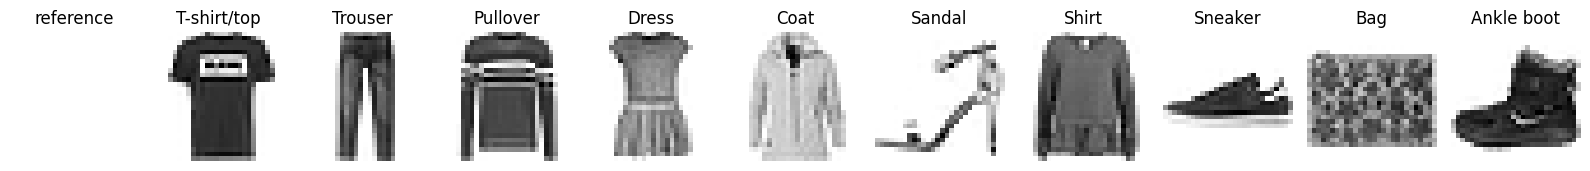

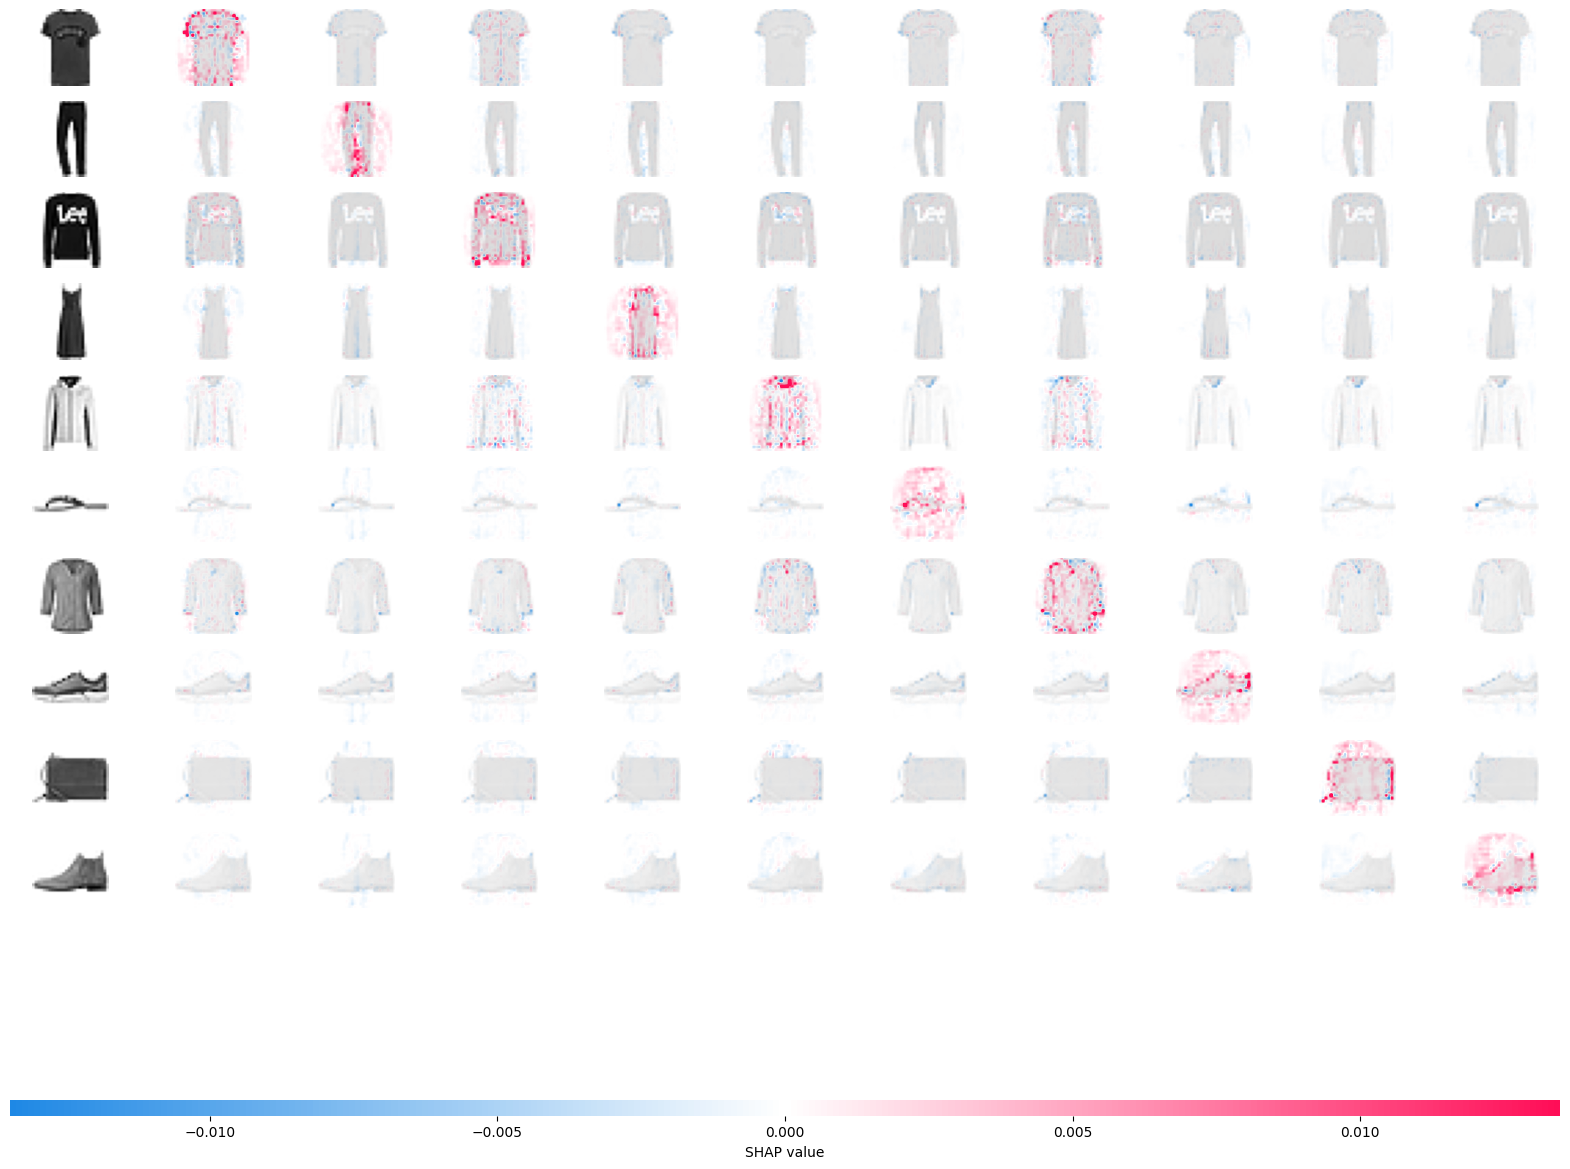

In [9]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

In [10]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
    print(class_names[i])

Coat
Pullover
Shirt
